In [1]:
import torch
import torch.utils.data as data
import torchnet as tnt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
import json
import pickle as pkl
import argparse
import pprint

/home/mhbokaei/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.__version__


'1.12.1+cu116'

In [3]:
from models.stclassifier import PseTae
from dataset import PixelSetData, PixelSetData_preloaded
from learning.focal_loss import FocalLoss
from learning.weight_init import weight_init
from learning.metrics import mIou, confusion_matrix_analysis

In [4]:

def train_epoch(model, optimizer, criterion, data_loader, device, args):
    acc_meter = tnt.meter.ClassErrorMeter(accuracy=True)
    loss_meter = tnt.meter.AverageValueMeter()
    y_true = []
    y_pred = []

    for i, (x, y) in enumerate(data_loader):

        y_true.extend(list(map(int, y)))

        x = recursive_todevice(x, device)
        y = y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y.long())
        loss.backward()
        optimizer.step()

        pred = out.detach()
        y_p = pred.argmax(dim=1).cpu().numpy()
        y_pred.extend(list(y_p))
        acc_meter.add(pred, y)
        loss_meter.add(loss.item())

        if (i + 1) % args['display_step'] == 0:
            print('Step [{}/{}], Loss: {:.4f}, Acc : {:.2f}'.format(i + 1, len(data_loader), loss_meter.value()[0],
                                                                    acc_meter.value()[0]))

    epoch_metrics = {'train_loss': loss_meter.value()[0],
                     'train_accuracy': acc_meter.value()[0],
                     'train_IoU': mIou(y_true, y_pred, n_classes=args['num_classes'])}

    return epoch_metrics


def evaluation(model, criterion, loader, device, args, mode='val'):
    y_true = []
    y_pred = []

    acc_meter = tnt.meter.ClassErrorMeter(accuracy=True)
    loss_meter = tnt.meter.AverageValueMeter()

    for (x, y) in loader:
        y_true.extend(list(map(int, y)))
        x = recursive_todevice(x, device)
        y = y.to(device)

        with torch.no_grad():
            prediction = model(x)
            loss = criterion(prediction, y)

        acc_meter.add(prediction, y)
        loss_meter.add(loss.item())

        y_p = prediction.argmax(dim=1).cpu().numpy()
        y_pred.extend(list(y_p))

    metrics = {'{}_accuracy'.format(mode): acc_meter.value()[0],
               '{}_loss'.format(mode): loss_meter.value()[0],
               '{}_IoU'.format(mode): mIou(y_true, y_pred, args['num_classes'])}

    if mode == 'val':
        return metrics
    elif mode == 'test':
        return metrics, confusion_matrix(y_true, y_pred, labels=list(range(args['num_classes'])))


def get_loaders(dt, kfold, args):
    indices = list(range(len(dt)))
    np.random.shuffle(indices)

    kf = KFold(n_splits=kfold, shuffle=False)
    indices_seq = list(kf.split(list(range(len(dt)))))
    ntest = len(indices_seq[0][1])

    loader_seq = []
    for trainval, test_indices in indices_seq:
        trainval = [indices[i] for i in trainval]
        test_indices = [indices[i] for i in test_indices]

        validation_indices = trainval[-ntest:]
        train_indices = trainval[:-ntest]

        train_sampler = data.sampler.SubsetRandomSampler(train_indices)
        validation_sampler = data.sampler.SubsetRandomSampler(validation_indices)
        test_sampler = data.sampler.SubsetRandomSampler(test_indices)

        train_loader = data.DataLoader(dt, batch_size=args['batch_size'],
                                       sampler=train_sampler,
                                       num_workers=args['num_workers'])
        validation_loader = data.DataLoader(dt, batch_size=args['batch_size'],
                                            sampler=validation_sampler,
                                            num_workers=args['num_workers'])
        test_loader = data.DataLoader(dt, batch_size=args['batch_size'],
                                      sampler=test_sampler,
                                      num_workers=args['num_workers'])

        loader_seq.append((train_loader, validation_loader, test_loader))
    return loader_seq


def get_loaders_sepT(dt,dt_sepT, kfold, args):
    indices = list(range(len(dt)))
    indices_T = list(range(len(dt_sepT)))
    np.random.shuffle(indices)
    np.random.shuffle(indices_T)


    kf = KFold(n_splits=kfold, shuffle=False)
    indices_seq = list(kf.split(list(range(len(dt)))))
    indices_seq_T = list(range(len(dt_sepT)))

    def add_element(main_matrix, 
                    temp_matrix = indices_seq_T):
        main_matrix = list(main_matrix)
        main_matrix.append(temp_matrix)
        main_matrix = tuple(main_matrix)
        return main_matrix

    indices_seqq = tuple(map(add_element , indices_seq))

    loader_seq = []
    for train_indices, validation_indices, test_indices in indices_seqq:
        train_indices = [indices[i] for i in train_indices]
        validation_indices = [indices[i] for i in validation_indices]
        test_indices = [indices_T[i] for i in test_indices]
        
        train_sampler = data.sampler.SubsetRandomSampler(train_indices)
        validation_sampler = data.sampler.SubsetRandomSampler(validation_indices)
        test_sampler = data.sampler.SubsetRandomSampler(test_indices)

        train_loader = data.DataLoader(dt, batch_size=args['batch_size'],
                                       sampler=train_sampler,
                                       num_workers=args['num_workers'])
        validation_loader = data.DataLoader(dt, batch_size=args['batch_size'],
                                            sampler=validation_sampler,
                                            num_workers=args['num_workers'])
        test_loader = data.DataLoader(dt_sepT, batch_size=args['batch_size'],
                                      sampler=test_sampler,
                                      num_workers=args['num_workers'])

        loader_seq.append((train_loader, validation_loader, test_loader))
    return loader_seq

def recursive_todevice(x, device):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    else:
        return [recursive_todevice(c, device) for c in x]


def prepare_output(args):
    os.makedirs(args['res_dir'], exist_ok=True)
    for fold in range(1, args['kfold'] + 1):
        os.makedirs(os.path.join(args['res_dir'], 'Fold_{}'.format(fold)), exist_ok=True)


def checkpoint(fold, log, args):
    with open(os.path.join(args['res_dir'], 'Fold_{}'.format(fold), 'trainlog.json'), 'w') as outfile:
        json.dump(log, outfile, indent=4)


def save_results(fold, metrics, conf_mat, args):
    with open(os.path.join(args['res_dir'], 'Fold_{}'.format(fold), 'test_metrics.json'), 'w') as outfile:
        json.dump(metrics, outfile, indent=4)
    pkl.dump(conf_mat, open(os.path.join(args['res_dir'], 'Fold_{}'.format(fold), 'conf_mat.pkl'), 'wb'))
    ########Confusion Matrix Display#######er
    #labelss = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s']
    #disp = ConfusionMatrixDisplay(confusion_matrix=mat, display_labels =labelss)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    fig, ax = plt.subplots(figsize=(21, 17))  # Set desired width and height
    disp.plot(ax=ax)
    # Customize additional plot elements as needed (e.g., fontsize, colormap)
    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust tick label fontsize
    plt.setp(disp.ax_.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.setp(disp.ax_.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.tight_layout()
    save_path_cm = os.path.join(args['res_dir'],'Fold_{}'.format(fold), "confusion_matrix.png")
    plt.savefig(save_path_cm)
    #plt.show() 

########Number of classes#######er
def point_plot(data,
               D_list,  ##List of deleted classes
               path : str,
               x_lable : str,
               y_lable : str,
               title : str):
    
    for i in D_list:
     del data[i]
    
    plt.figure(figsize=(15, 10))

    x = list(data.keys())
    y = list(data.values())
    x = list(map(lambda x : str(x), x))

    for _x, _y in zip(x, y):
        plt.text(_x, _y, f'{_y:.0f}', fontsize=9, ha='center', va='bottom')
    plt.plot(x, y, marker='o', linestyle='--')
    plt.xlabel(x_lable)
    plt.ylabel(y_lable)
    plt.title(title)
    plt.grid(True)
    plt.savefig(path)
    print("data.keys():", data.keys())
    print("len(data.keys()):", len(data.keys()))
    #plt.show()
    plt.close()

def overall_performance(args):
    cm = np.zeros((args['num_classes'], args['num_classes']))
    for fold in range(1, args['kfold'] + 1):
        cm += pkl.load(open(os.path.join(args['res_dir'], 'Fold_{}'.format(fold), 'conf_mat.pkl'), 'rb'))

    _, perf = confusion_matrix_analysis(cm)

    print('Overall performance:')
    print('Acc: {},  IoU: {}'.format(perf['Accuracy'], perf['MACRO_IoU']))

    with open(os.path.join(args['res_dir'], 'overall.json'), 'w') as file:
        file.write(json.dumps(perf, indent=4))


def main(args):
    np.random.seed(args['rdm_seed'])
    torch.manual_seed(args['rdm_seed'])
    prepare_output(args)
    mean_std = pkl.load(open(args['dataset_folder'] + '/S2-2017-T31TFM-meanstd.pkl', 'rb'))
    mean_std_sepT = pkl.load(open(args['dataset_folder_sepT'] + '/S2-2017-T31TFM-meanstd.pkl', 'rb'))

    # 19 - 44 classes None

    extra = 'geomfeat' if args['geomfeat'] else None

    if args['preload']:
        dt = PixelSetData_preloaded(args['dataset_folder'], labels='label_19class', npixel=args['npixel'],
                          sub_classes= None,
                          norm=mean_std,
                          extra_feature=extra)
        dt_sepT = PixelSetData_preloaded(args['dataset_folder_sepT'], labels='label_19class', npixel=args['npixel'],
                          sub_classes= None,
                          norm=mean_std_sepT,
                          extra_feature=extra)        
    else:
        dt = PixelSetData(args['dataset_folder'], labels='label_19class', npixel=args['npixel'],
                          sub_classes= None,
                          norm=mean_std,
                          extra_feature=extra)
        dt_sepT = PixelSetData(args['dataset_folder_sepT'], labels='label_19class', npixel=args['npixel'],
                          sub_classes= None,
                          norm=mean_std_sepT,
                          extra_feature=extra)        
        
    device = torch.device(args['device'])
    print("len(dt)1: ",len(dt))

    if args['separate_test'] == 'yes' :
        loaders = get_loaders_sepT(dt, dt_sepT, args['kfold'], args)
    elif args['separate_test'] == 'no':
        loaders = get_loaders(dt, args['kfold'], args)
#########number of classes############er
    with open(os.path.join(args['dataset_folder'], 'META', 'labels.json'), 'r') as file:
        data = json.load(file)
    class_19 = list(data["label_19class"].values())
    print("len(class_19):", len(class_19),", min(class_19):", min(class_19), ", max(class_19):", max(class_19) )

    counter = {}
    for _class in class_19:
        if _class in counter:
            counter[_class] += 1
        elif _class not in counter:
            counter[_class] = 0
    counter = dict(sorted(counter.items(), key=lambda item:item[0]))
    save_path_cn = os.path.join(args['res_dir'], "number_of_classes.png")
    point_plot(counter,[], save_path_cn, "Classes", "Number", "Number of each class")
##############################

    for fold, (train_loader, val_loader, test_loader) in enumerate(loaders):
        print("len(dt)0: ",len(dt))
        print("len(dt_sepT)0: ",len(dt_sepT))
        print('Starting Fold {}'.format(fold + 1))
        print('Train {}, Val {}, Test {}'.format(len(train_loader), len(val_loader), len(test_loader)))
        print("test_loader: ", test_loader)

        model_args= dict(input_dim=args['input_dim'], mlp1=args['mlp1'], pooling=args['pooling'],
                            mlp2=args['mlp2'], n_head=args['n_head'], d_k=args['d_k'], mlp3=args['mlp3'],
                            dropout=args['dropout'], T=args['T'], len_max_seq=args['lms'],
                            positions=dt.date_positions if args['positions'] == 'bespoke' else None,
                            mlp4=args['mlp4'])

        if args['geomfeat']:
            model_args.update(with_extra=True, extra_size=4)
        else:
            model_args.update(with_extra=False, extra_size=None)

        model = PseTae(**model_args)

        print(model.param_ratio())

        model = model.to(device)
        model.apply(weight_init)
        optimizer = torch.optim.Adam(model.parameters())
        criterion = FocalLoss(args['gamma'])

        trainlog = {}



        best_mIoU = 0

        training_history = {'train_accuracy': [], 'train_loss': [], 'val_accuracy': [], 'val_loss': []} #Er

        for epoch in range(1, args['epochs'] + 1):
            print('EPOCH {}/{}'.format(epoch, args['epochs']))


            model.train()
            train_metrics = train_epoch(model, optimizer, criterion, train_loader, device=device, args=args)

            print('Validation . . . ')
            model.eval()
            val_metrics = evaluation(model, criterion, val_loader, device=device, args=args, mode='val')

            print('Loss {:.4f},  Acc {:.2f},  IoU {:.4f}'.format(val_metrics['val_loss'], val_metrics['val_accuracy'],
                                                                 val_metrics['val_IoU']))

            
            trainlog[epoch] = {**train_metrics, **val_metrics}
            checkpoint(fold + 1, trainlog, args)

            ###############Prepare Accuracy and Loss Data for Plot##er 
            training_history['train_accuracy'].append(train_metrics['train_accuracy'])           
            training_history['train_loss'].append(train_metrics['train_loss'])   
            training_history['val_accuracy'].append(val_metrics['val_accuracy'])          
            training_history['val_loss'].append(val_metrics['val_loss'])   

            if val_metrics['val_IoU'] >= best_mIoU:
                best_mIoU = val_metrics['val_IoU']
                torch.save({'epoch': epoch, 'state_dict': model.state_dict(),
                            'optimizer': optimizer.state_dict()},
                           os.path.join(args['res_dir'], 'Fold_{}'.format(fold + 1), 'model.pth.tar'))

        
        #############Plot the Accuracy and Loss###########er
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))  # Adjust figsize as needed
        ax1.plot(training_history["train_accuracy"], label="train_accuracy", lw = 3, linestyle ='-')
        ax1.plot(training_history["val_accuracy"], label="val_accuracy", lw = 3, linestyle ='--')
        ax1.set_ylabel('Accuracy (%)', fontsize=15)
        ax1.set_xlabel('Epoch', fontsize=15)
        ax1.legend()
        ax1.tick_params(axis='both', which='major', labelsize=15)
        ax2.plot(training_history["train_loss"], label="train_loss", lw = 3, linestyle ='-')
        ax2.plot(training_history["val_loss"], label="val_loss", lw = 3, linestyle ='--')
        ax2.set_ylabel('Loss ', fontsize=15)
        ax2.set_xlabel('Epoch', fontsize=15)
        ax2.legend()
        ax2.tick_params(axis='both', which='major', labelsize=15)
        plt.tight_layout()
        save_path = os.path.join(args['res_dir'],'Fold_{}'.format(fold+1), "evplot.png")
        plt.savefig(save_path)

               
        print('Testing best epoch . . .')
        model.load_state_dict(
            torch.load(os.path.join(args['res_dir'], 'Fold_{}'.format(fold + 1), 'model.pth.tar'))['state_dict'])
        model.eval()

        test_metrics, conf_mat = evaluation(model, criterion, test_loader, device=device, mode='test', args=args)

        print('Loss {:.4f},  Acc {:.2f},  IoU {:.4f}'.format(test_metrics['test_loss'], test_metrics['test_accuracy'],
                                                             test_metrics['test_IoU']))
        save_results(fold + 1, test_metrics, conf_mat, args)

    overall_performance(args)



In [5]:

if __name__ == '__main__':

    parser = argparse.ArgumentParser()

    # Set-up parameters
    # /home/mhbokaei/shakouri/test/Satellite/dataset_folder100
    # /home/mhbokaei/shakouri/test/Satellite/dataset_folder10000
    # /home/mhbokaei/shakouri/test/Satellite/dataset_folder90000
    # /home/mhbokaei/shakouri/SatelliteImage_TimeSeries_Classification/dataset_folder
    
    
    parser.add_argument('--dataset_folder', default='/home/mhbokaei/shakouri/SatelliteImage_TimeSeries_Classification/dataset_folder', type=str,
                        help='Path to the folder where the results are saved.')
    parser.add_argument('--dataset_folder_sepT', default='/home/mhbokaei/shakouri/test/Satellite/dataset_folder100', type=str,
                        help='Path to the folder where the results are saved.')
    parser.add_argument('--separate_test', default='no', type=str, help='Shows the dataset for Test is different')

    parser.add_argument('--res_dir', default='./results', help='Path to the folder where the results should be stored')
    parser.add_argument('--num_workers', default=8, type=int, help='Number of data loading workers')
    parser.add_argument('--rdm_seed', default=1, type=int, help='Random seed')
    parser.add_argument('--device', default='cuda', type=str,
                        help='Name of device to use for tensor computations (cuda/cpu)')
    parser.add_argument('--display_step', default=20, type=int,
                        help='Interval in batches between display of training metrics')
    parser.add_argument('--preload', dest='preload', action='store_true',
                        help='If specified, the whole dataset is loaded to RAM at initialization')
    parser.set_defaults(preload=False)

    # Training parameters
    parser.add_argument('--kfold', default=5, type=int, help='Number of folds for cross validation')
    parser.add_argument('--epochs', default=3, type=int, help='Number of epochs per fold')
    parser.add_argument('--batch_size', default=512, type=int, help='Batch size')
    parser.add_argument('--lr', default=0.001, type=float, help='Learning rate')
    parser.add_argument('--gamma', default=1, type=float, help='Gamma parameter of the focal loss')
    parser.add_argument('--npixel', default=2, type=int, help='Number of pixels to sample from the input images')

    # Architecture Hyperparameters
    ## PSE
    parser.add_argument('--input_dim', default=10, type=int, help='Number of channels of input images')
    parser.add_argument('--mlp1', default='[10,32,64]', type=str, help='Number of neurons in the layers of MLP1')
    parser.add_argument('--pooling', default='mean_std', type=str, help='Pixel-embeddings pooling strategy')
    parser.add_argument('--mlp2', default='[132,128]', type=str, help='Number of neurons in the layers of MLP2')
    parser.add_argument('--geomfeat', default=1, type=int,
                        help='If 1 the precomputed geometrical features (f) are used in the PSE.')

    ## TAE
    parser.add_argument('--n_head', default=4, type=int, help='Number of attention heads')
    parser.add_argument('--d_k', default=32, type=int, help='Dimension of the key and query vectors')
    parser.add_argument('--mlp3', default='[512,128,128]', type=str, help='Number of neurons in the layers of MLP3')
    parser.add_argument('--T', default=1000, type=int, help='Maximum period for the positional encoding')
    parser.add_argument('--positions', default='bespoke', type=str,
                        help='Positions to use for the positional encoding (bespoke / order)')
    parser.add_argument('--lms', default=None, type=int,
                        help='Maximum sequence length for positional encoding (only necessary if positions == order)')
    parser.add_argument('--dropout', default=0.2, type=float, help='Dropout probability')

    ## Classifier
    parser.add_argument('--num_classes', default=19, type=int, help='Number of classes')
    parser.add_argument('--mlp4', default='[128, 64, 32, 19]', type=str, help='Number of neurons in the layers of MLP4')



{'T': 1000,
 'batch_size': 512,
 'd_k': 32,
 'dataset_folder': '/home/mhbokaei/shakouri/SatelliteImage_TimeSeries_Classification/dataset_folder',
 'dataset_folder_sepT': '/home/mhbokaei/shakouri/test/Satellite/dataset_folder100',
 'device': 'cuda',
 'display_step': 20,
 'dropout': 0.2,
 'epochs': 3,
 'gamma': 1,
 'geomfeat': 1,
 'input_dim': 10,
 'kfold': 5,
 'lms': None,
 'lr': 0.001,
 'mlp1': [10, 32, 64],
 'mlp2': [132, 128],
 'mlp3': [512, 128, 128],
 'mlp4': [128, 64, 32, 19],
 'n_head': 4,
 'npixel': 2,
 'num_classes': 19,
 'num_workers': 8,
 'pooling': 'mean_std',
 'positions': 'bespoke',
 'preload': False,
 'rdm_seed': 1,
 'res_dir': './results',
 'separate_test': 'no'}
len(dt)1:  191209
len(class_19): 199463 , min(class_19): 0 , max(class_19): 18
data.keys(): dict_keys([0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18])
len(data.keys()): 17


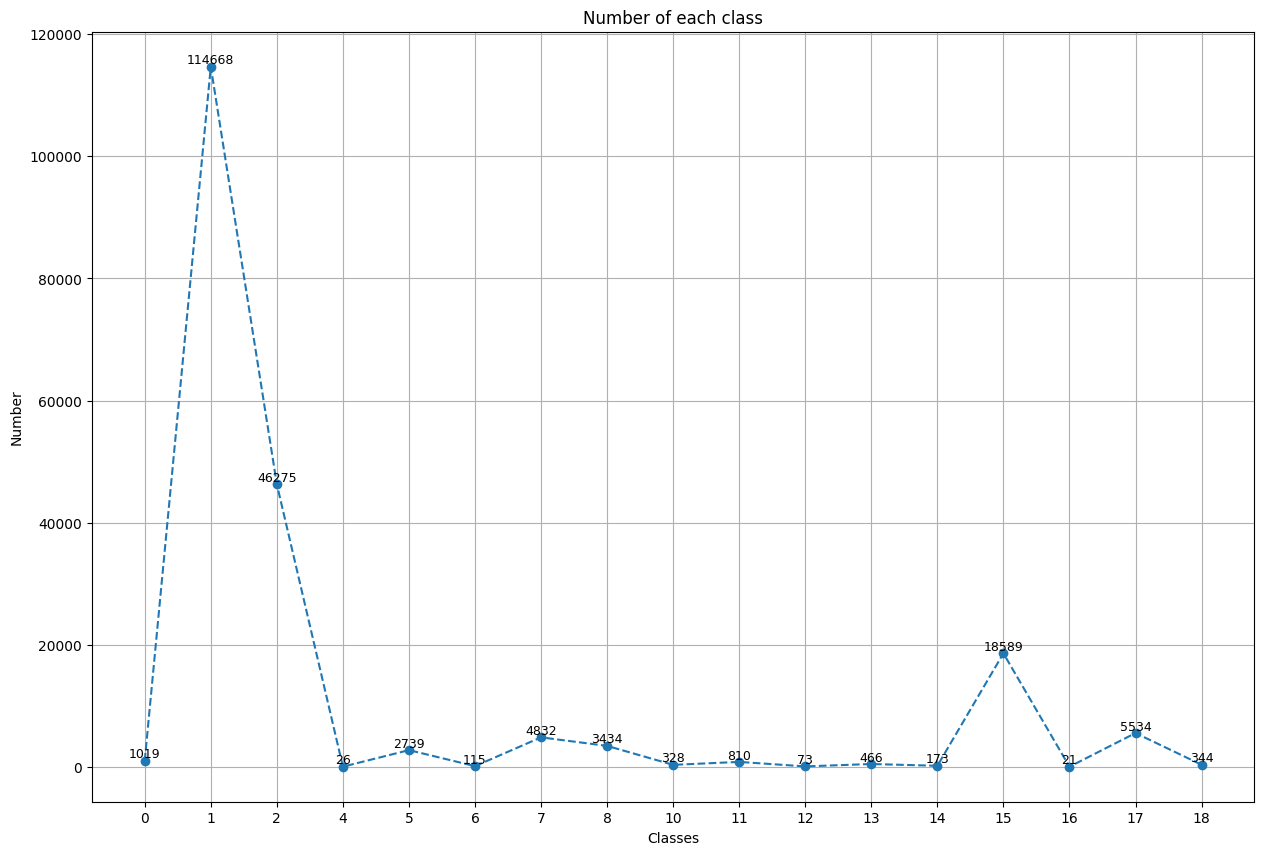

len(dt)0:  191209
len(dt_sepT)0:  98
Starting Fold 1
Train 225, Val 75, Test 75
test_loader:  <torch.utils.data.dataloader.DataLoader object at 0x7f9967571970>
TOTAL TRAINABLE PARAMETERS : 164083
RATIOS: Spatial  12.1% , Temporal  81.1% , Classifier   6.8%
None
EPOCH 1/3
Step [20/225], Loss: 1.9993, Acc : 27.49
Step [40/225], Loss: 1.5531, Acc : 52.52
Step [60/225], Loss: 1.2835, Acc : 63.39
Step [80/225], Loss: 1.1022, Acc : 69.55
Step [100/225], Loss: 0.9696, Acc : 73.61
Step [120/225], Loss: 0.8740, Acc : 76.35
Step [140/225], Loss: 0.7999, Acc : 78.37
Step [160/225], Loss: 0.7433, Acc : 79.85
Step [180/225], Loss: 0.6958, Acc : 81.05
Step [200/225], Loss: 0.6558, Acc : 82.07
Step [220/225], Loss: 0.6235, Acc : 82.84
Validation . . . 
Loss 0.2588,  Acc 91.29,  IoU 0.2582
EPOCH 2/3
Step [20/225], Loss: 0.2858, Acc : 90.93
Step [40/225], Loss: 0.2751, Acc : 91.02
Step [60/225], Loss: 0.2682, Acc : 91.15
Step [80/225], Loss: 0.2659, Acc : 91.15
Step [100/225], Loss: 0.2651, Acc : 91.12

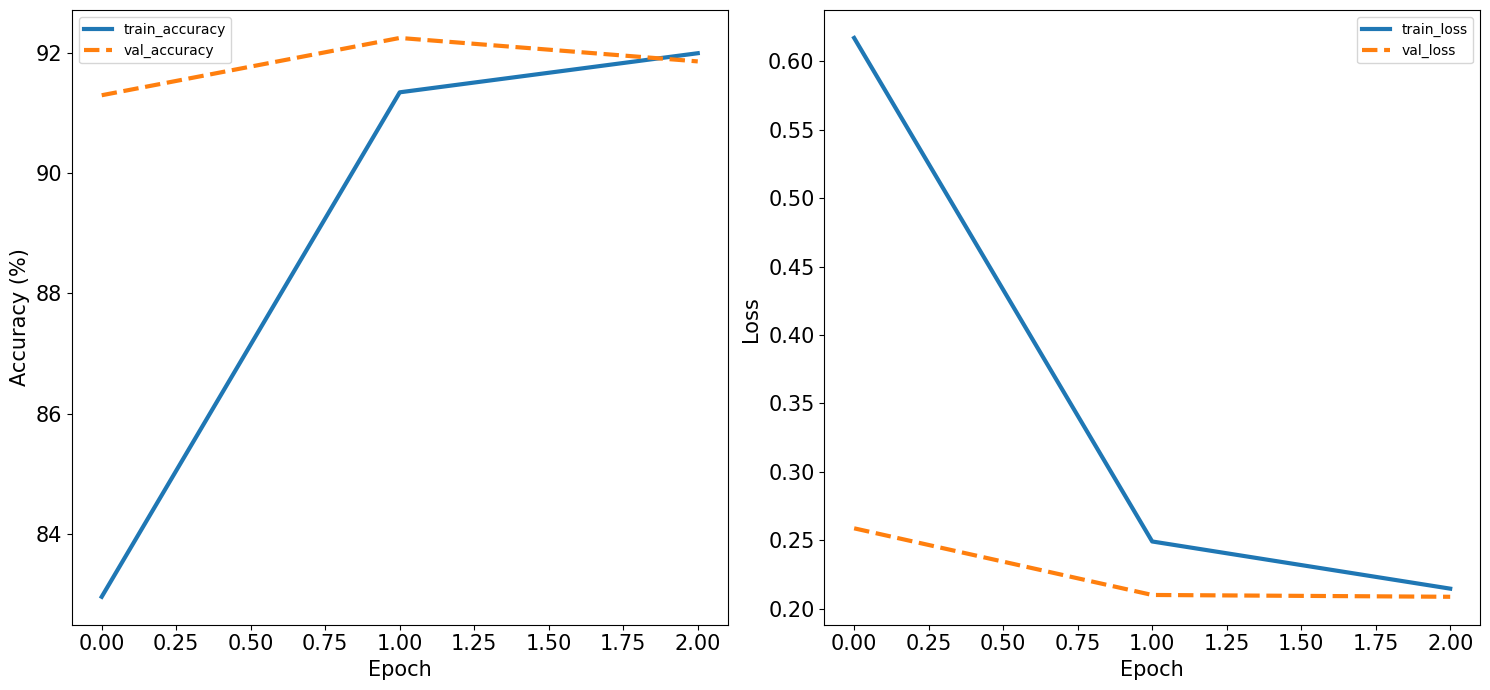

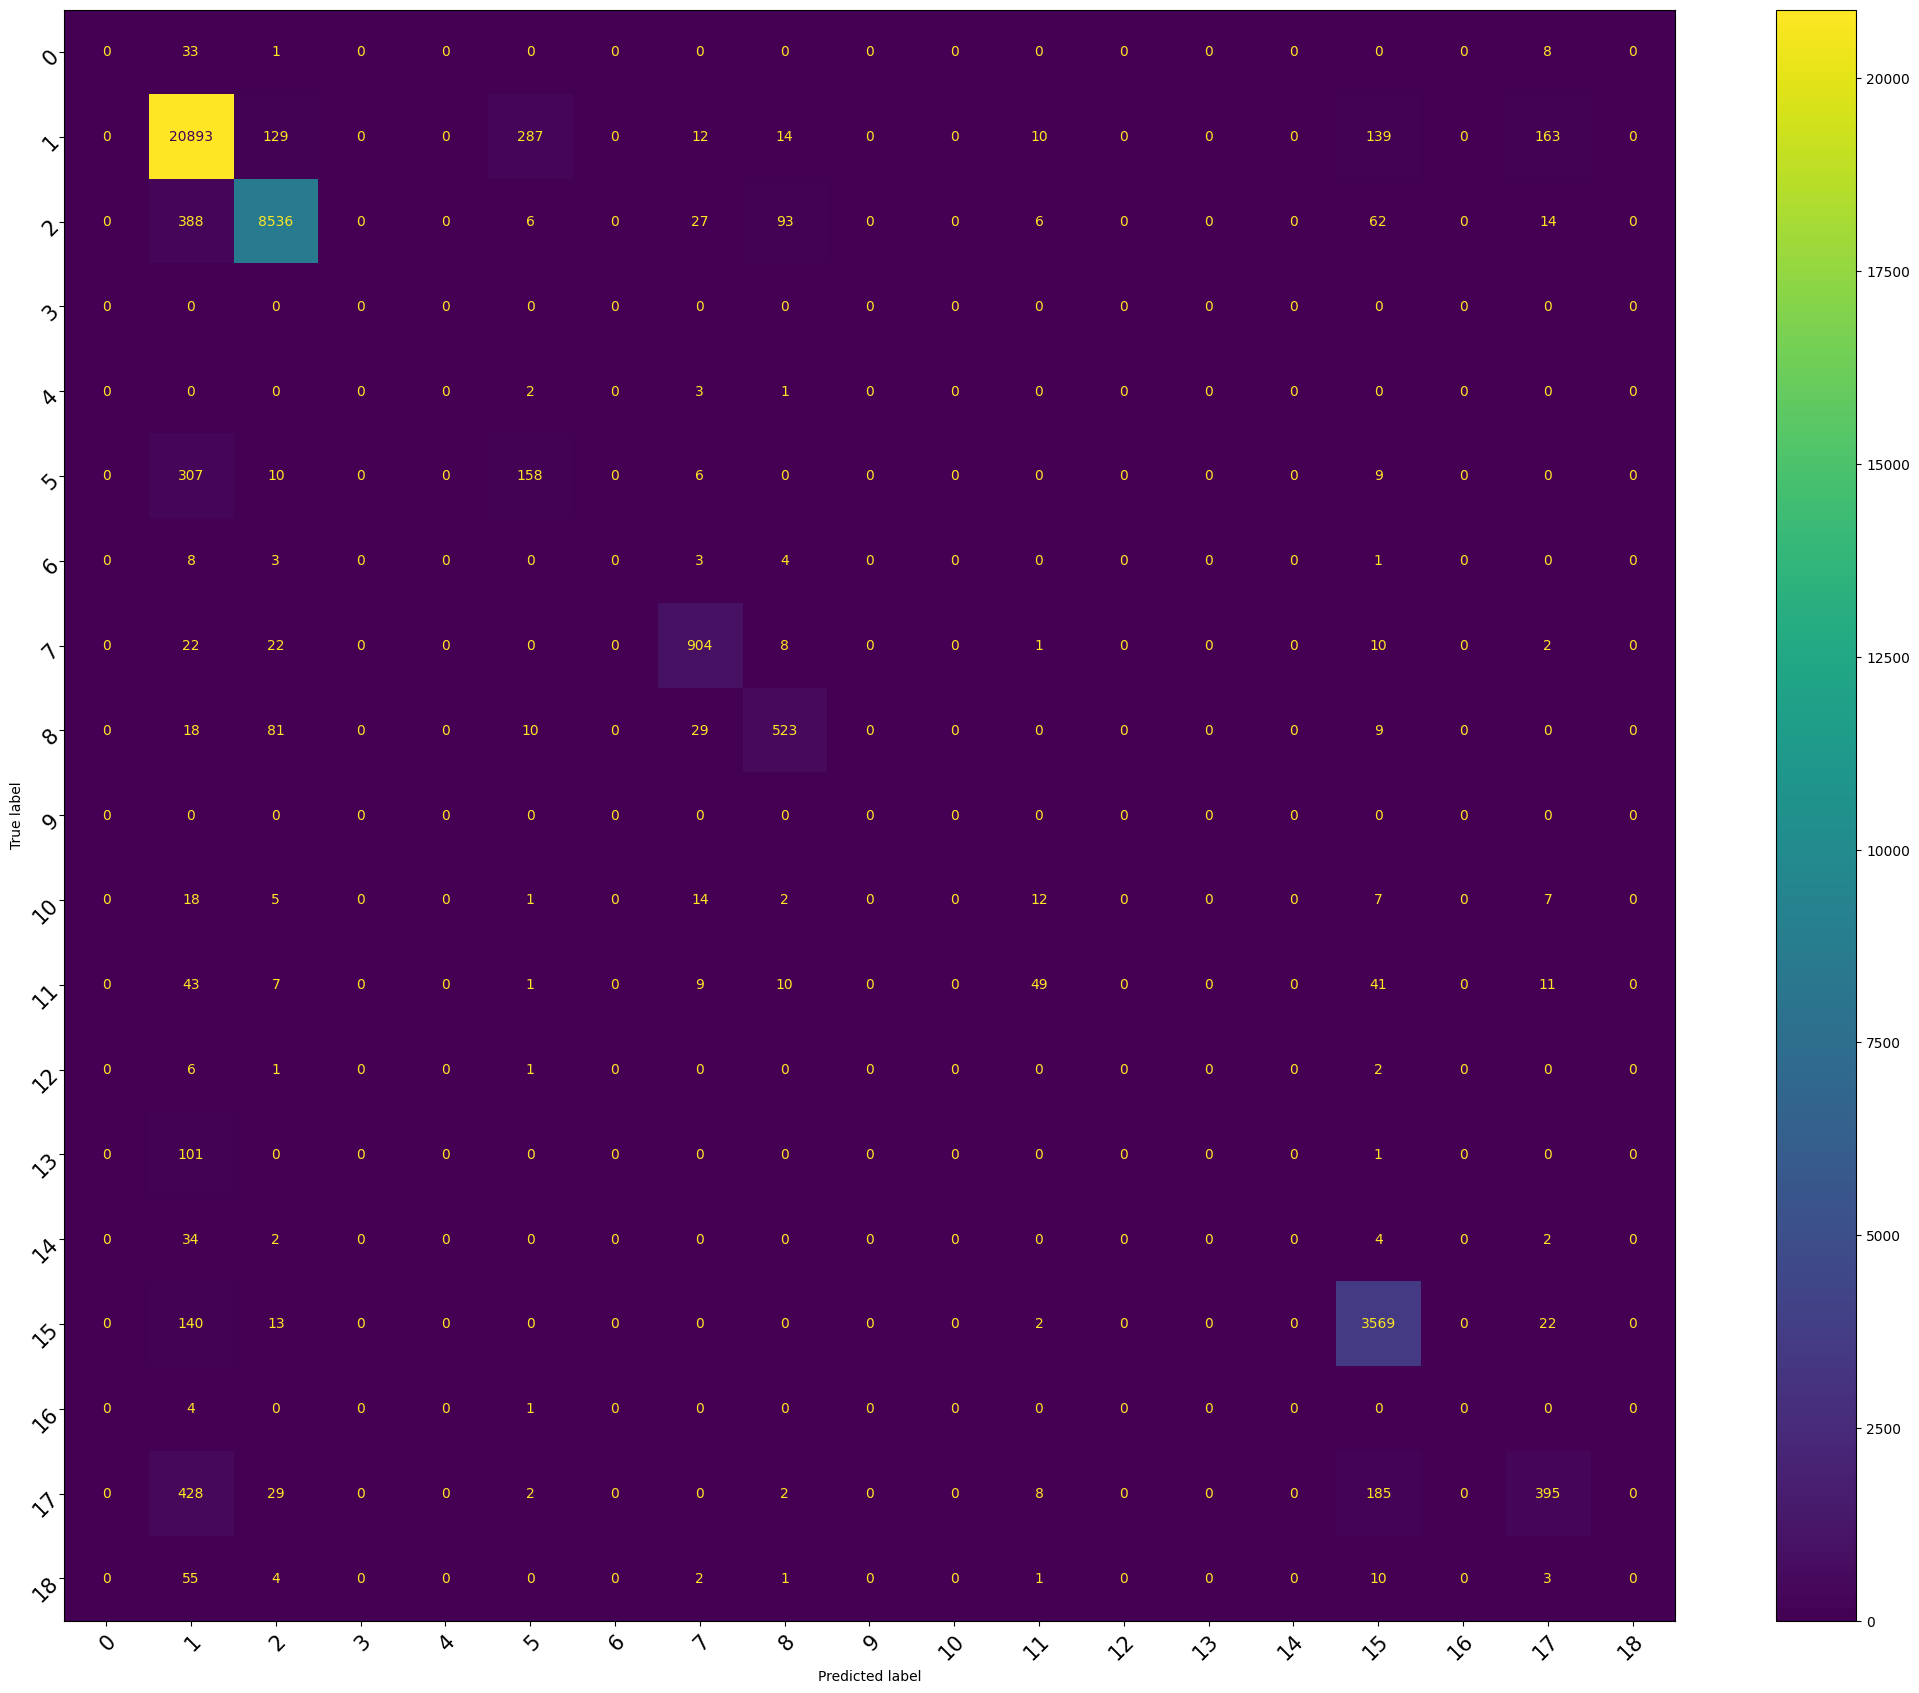

len(dt)0:  191209
len(dt_sepT)0:  98
Starting Fold 2
Train 225, Val 75, Test 75
test_loader:  <torch.utils.data.dataloader.DataLoader object at 0x7f9967571fa0>
TOTAL TRAINABLE PARAMETERS : 164083
RATIOS: Spatial  12.1% , Temporal  81.1% , Classifier   6.8%
None
EPOCH 1/3
Step [20/225], Loss: 2.5421, Acc : 6.14
Step [40/225], Loss: 2.1214, Acc : 20.03
Step [60/225], Loss: 1.7888, Acc : 38.17
Step [80/225], Loss: 1.5351, Acc : 49.88
Step [100/225], Loss: 1.3478, Acc : 57.53
Step [120/225], Loss: 1.2036, Acc : 62.93
Step [140/225], Loss: 1.0915, Acc : 66.89
Step [160/225], Loss: 1.0035, Acc : 69.79
Step [180/225], Loss: 0.9307, Acc : 72.12
Step [200/225], Loss: 0.8711, Acc : 73.99
Step [220/225], Loss: 0.8187, Acc : 75.57
Validation . . . 
Loss 0.2657,  Acc 91.60,  IoU 0.2555
EPOCH 2/3
Step [20/225], Loss: 0.2908, Acc : 91.02
Step [40/225], Loss: 0.2874, Acc : 90.99
Step [60/225], Loss: 0.2840, Acc : 90.94
Step [80/225], Loss: 0.2779, Acc : 91.07
Step [100/225], Loss: 0.2711, Acc : 91.24


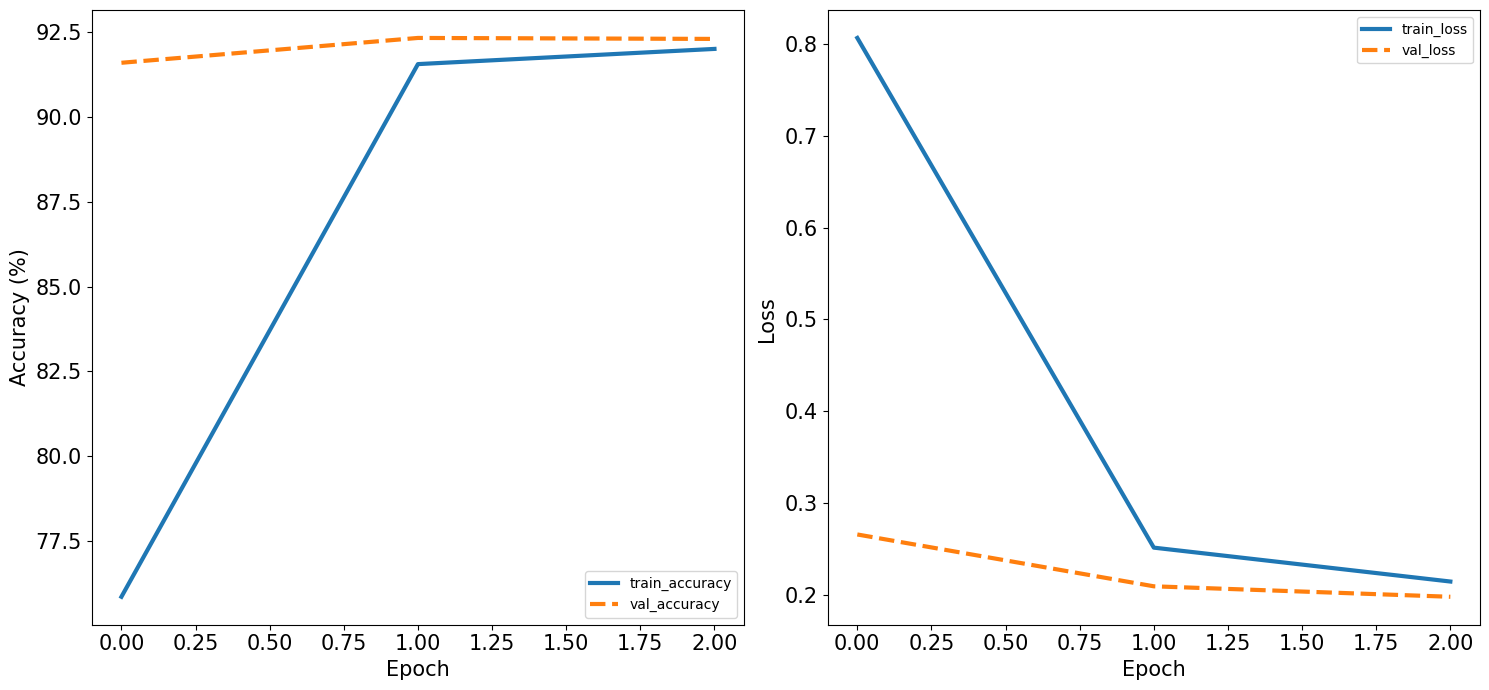

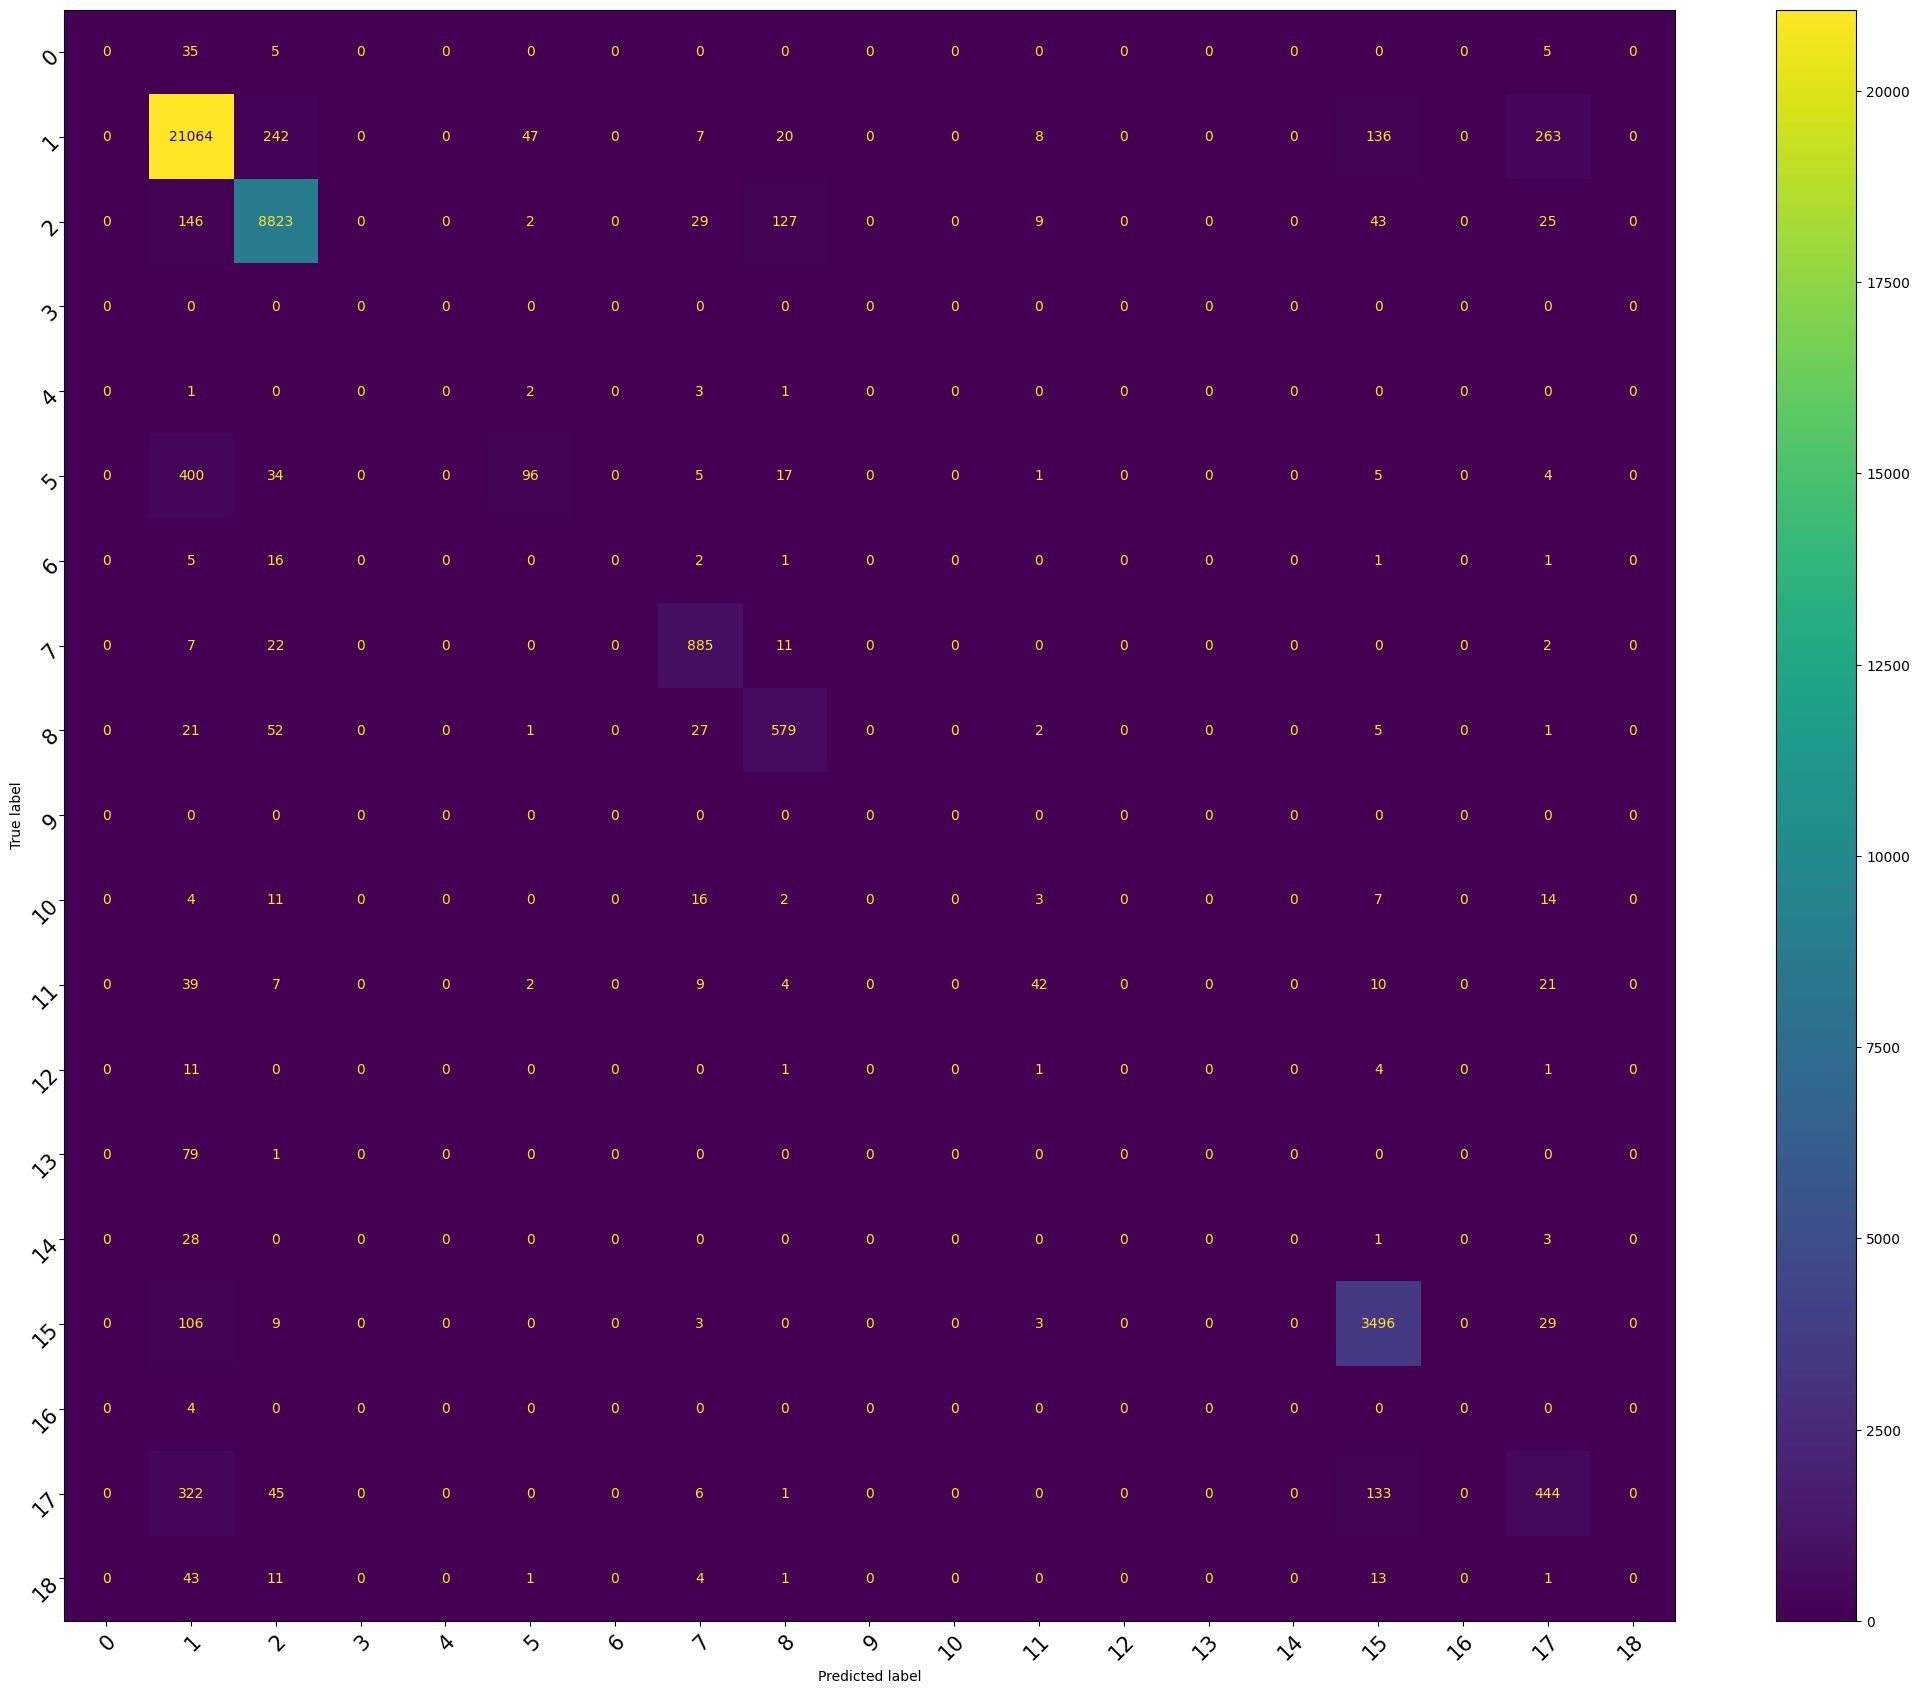

len(dt)0:  191209
len(dt_sepT)0:  98
Starting Fold 3
Train 225, Val 75, Test 75
test_loader:  <torch.utils.data.dataloader.DataLoader object at 0x7f99675715b0>
TOTAL TRAINABLE PARAMETERS : 164083
RATIOS: Spatial  12.1% , Temporal  81.1% , Classifier   6.8%
None
EPOCH 1/3
Step [20/225], Loss: 3.6621, Acc : 6.02
Step [40/225], Loss: 3.0382, Acc : 15.88
Step [60/225], Loss: 2.5881, Acc : 26.75
Step [80/225], Loss: 2.2413, Acc : 38.41
Step [100/225], Loss: 1.9685, Acc : 47.66
Step [120/225], Loss: 1.7499, Acc : 54.49
Step [140/225], Loss: 1.5790, Acc : 59.46
Step [160/225], Loss: 1.4394, Acc : 63.30
Step [180/225], Loss: 1.3235, Acc : 66.33
Step [200/225], Loss: 1.2294, Acc : 68.76
Step [220/225], Loss: 1.1505, Acc : 70.76
Validation . . . 
Loss 0.3016,  Acc 91.20,  IoU 0.2453
EPOCH 2/3
Step [20/225], Loss: 0.3401, Acc : 90.58
Step [40/225], Loss: 0.3289, Acc : 90.63
Step [60/225], Loss: 0.3165, Acc : 90.89
Step [80/225], Loss: 0.3082, Acc : 90.94
Step [100/225], Loss: 0.3022, Acc : 91.02


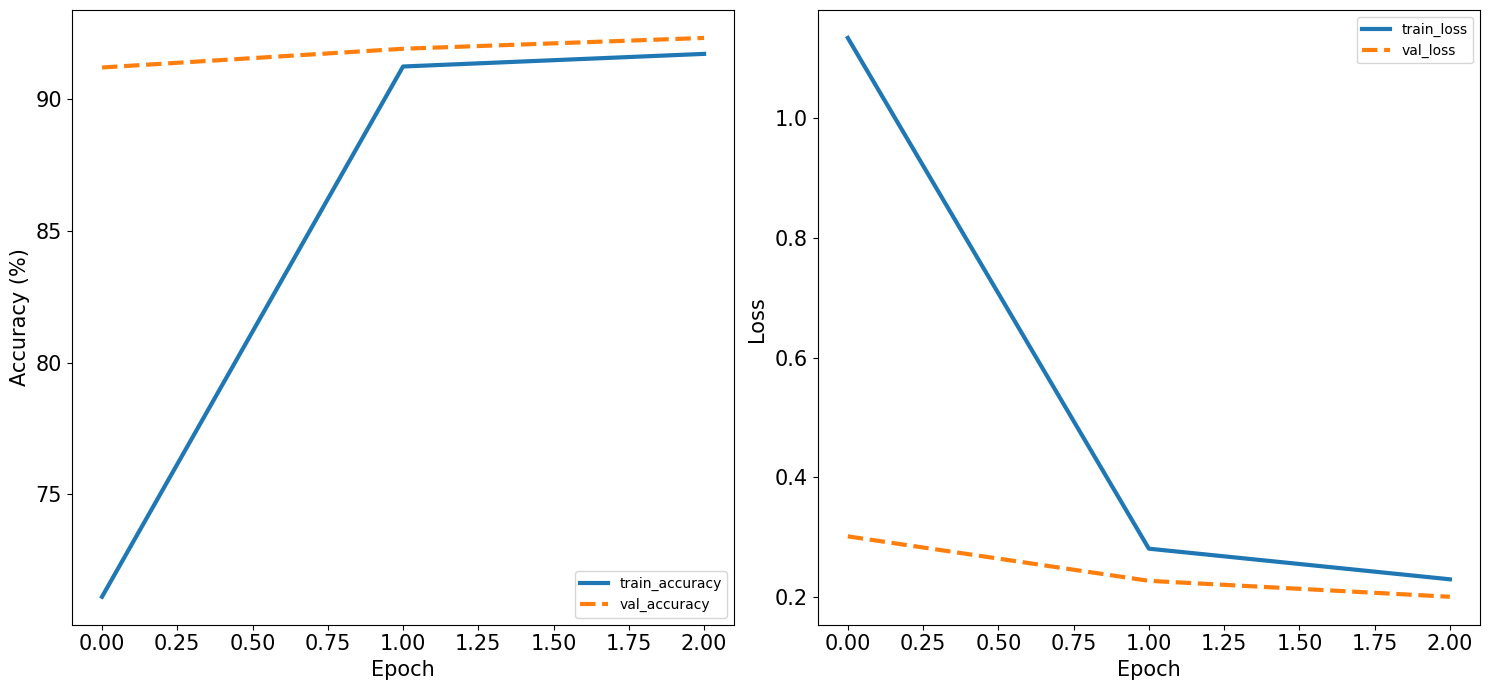

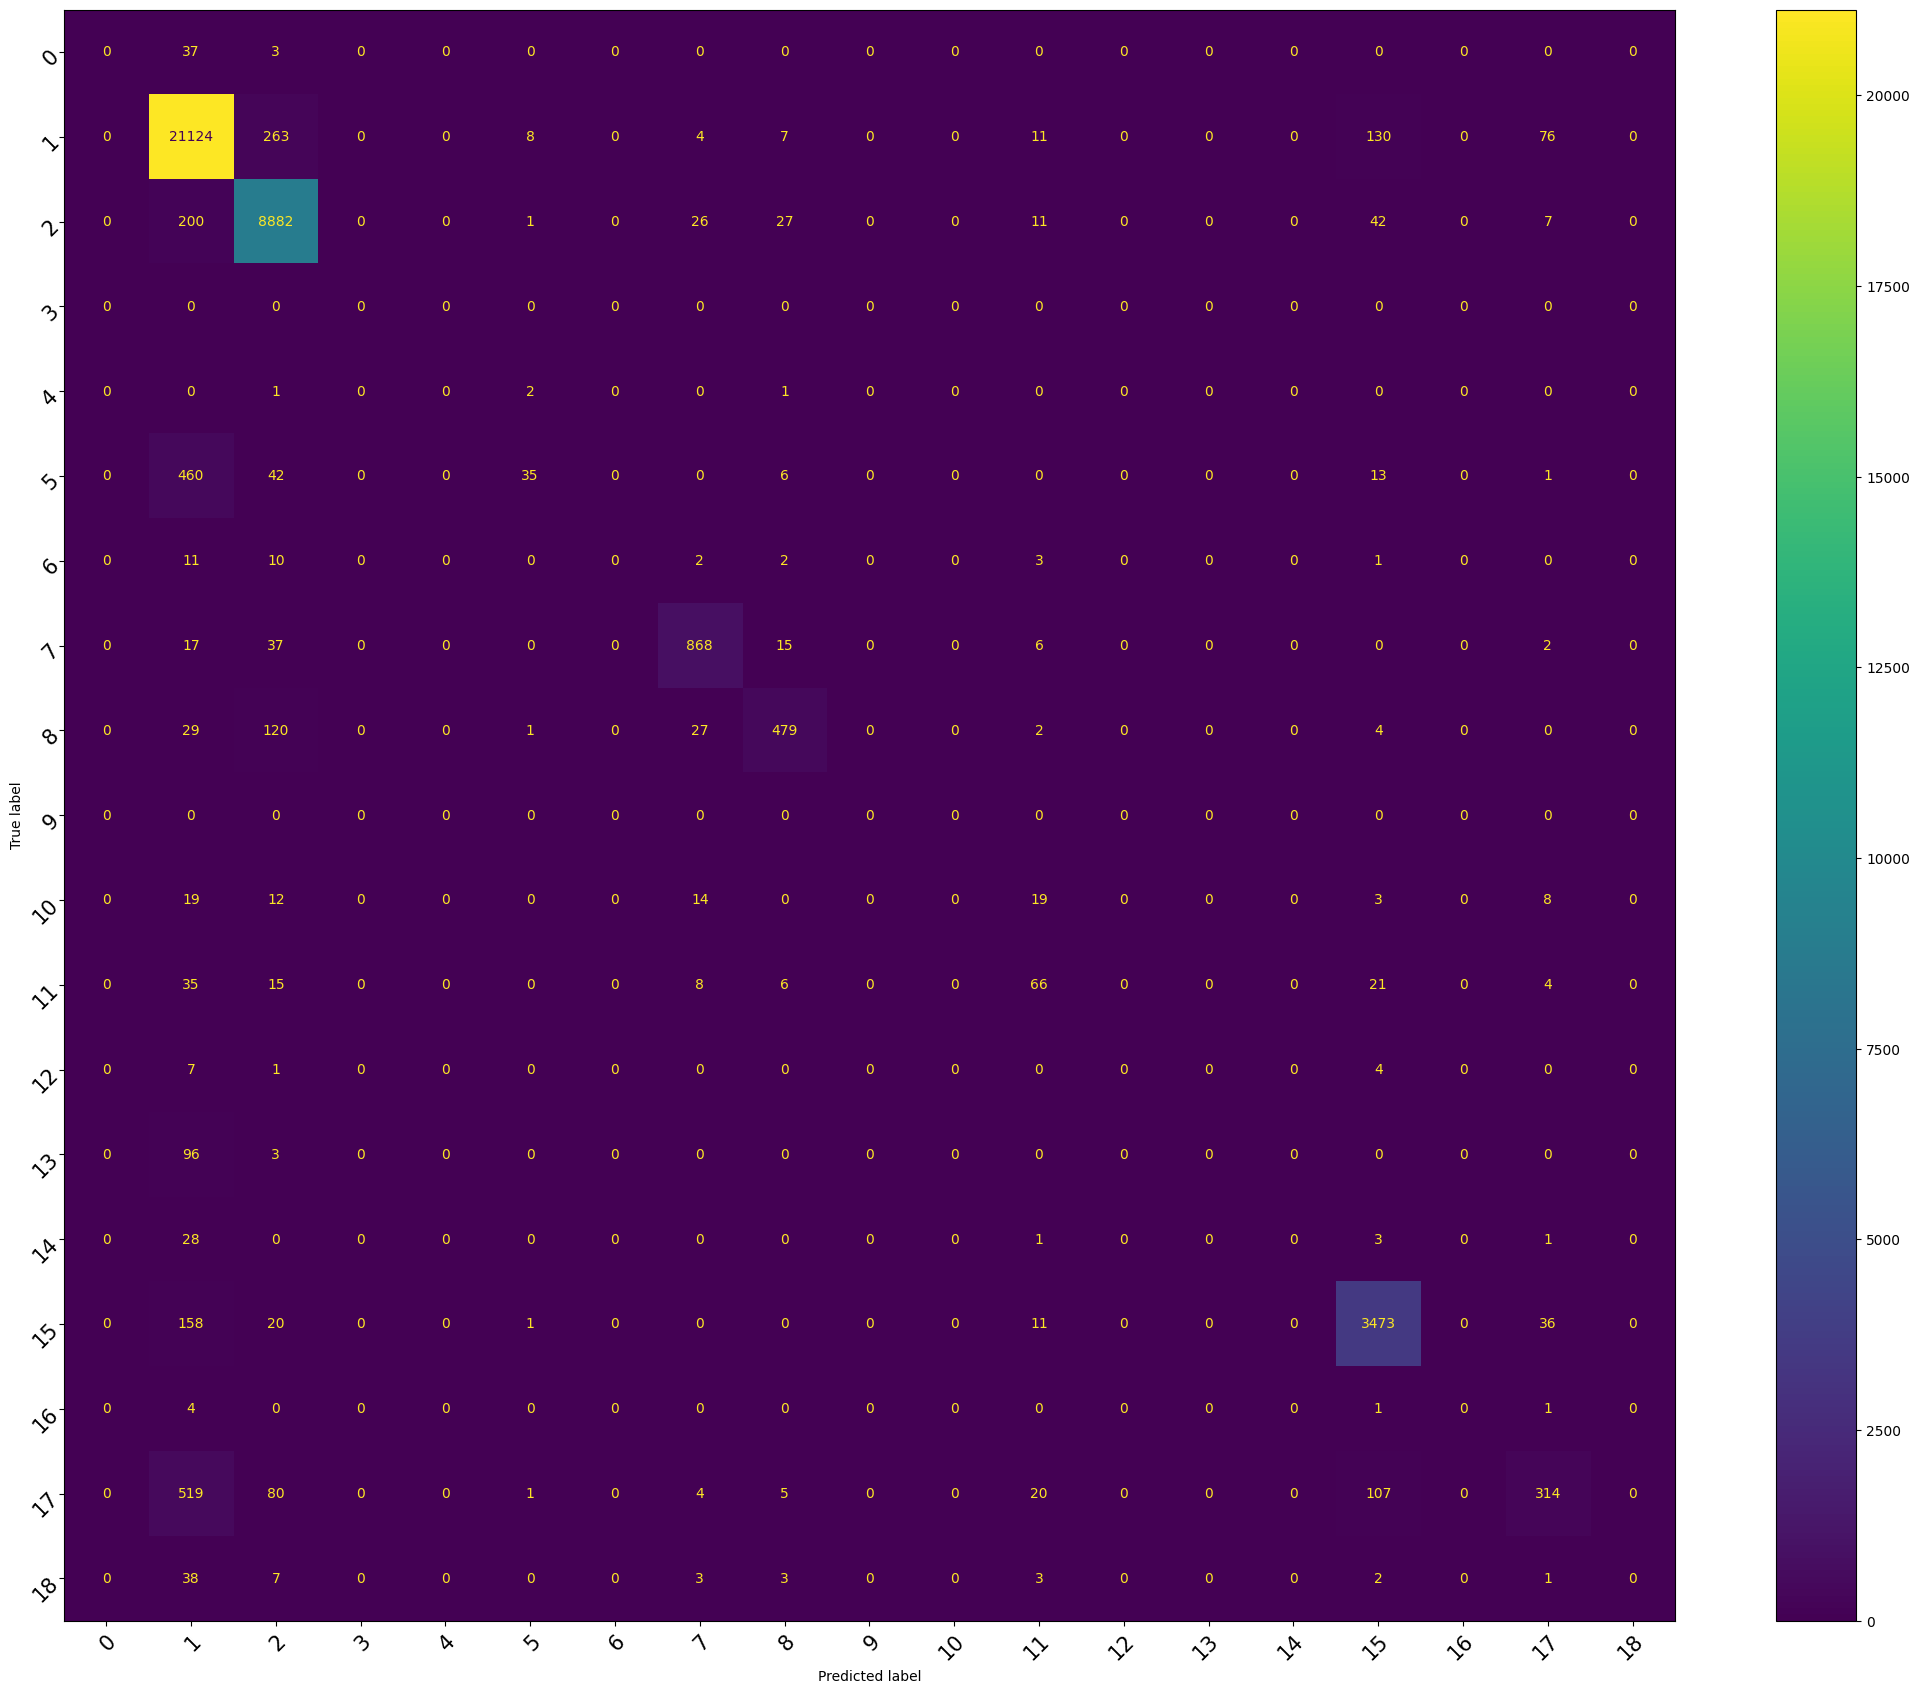

len(dt)0:  191209
len(dt_sepT)0:  98
Starting Fold 4
Train 225, Val 75, Test 75
test_loader:  <torch.utils.data.dataloader.DataLoader object at 0x7f99675711f0>
TOTAL TRAINABLE PARAMETERS : 164083
RATIOS: Spatial  12.1% , Temporal  81.1% , Classifier   6.8%
None
EPOCH 1/3
Step [20/225], Loss: 4.1442, Acc : 0.55
Step [40/225], Loss: 3.6602, Acc : 4.96
Step [60/225], Loss: 3.3076, Acc : 10.91
Step [80/225], Loss: 3.0200, Acc : 15.47
Step [100/225], Loss: 2.7684, Acc : 18.97
Step [120/225], Loss: 2.5417, Acc : 21.54
Step [140/225], Loss: 2.3341, Acc : 24.35
Step [160/225], Loss: 2.1492, Acc : 30.79
Step [180/225], Loss: 1.9820, Acc : 37.21
Step [200/225], Loss: 1.8354, Acc : 42.56
Step [220/225], Loss: 1.7087, Acc : 46.93
Validation . . . 
Loss 0.3732,  Acc 91.09,  IoU 0.2545
EPOCH 2/3
Step [20/225], Loss: 0.3974, Acc : 90.73
Step [40/225], Loss: 0.3835, Acc : 90.80
Step [60/225], Loss: 0.3690, Acc : 90.95
Step [80/225], Loss: 0.3586, Acc : 90.96
Step [100/225], Loss: 0.3481, Acc : 90.98
S

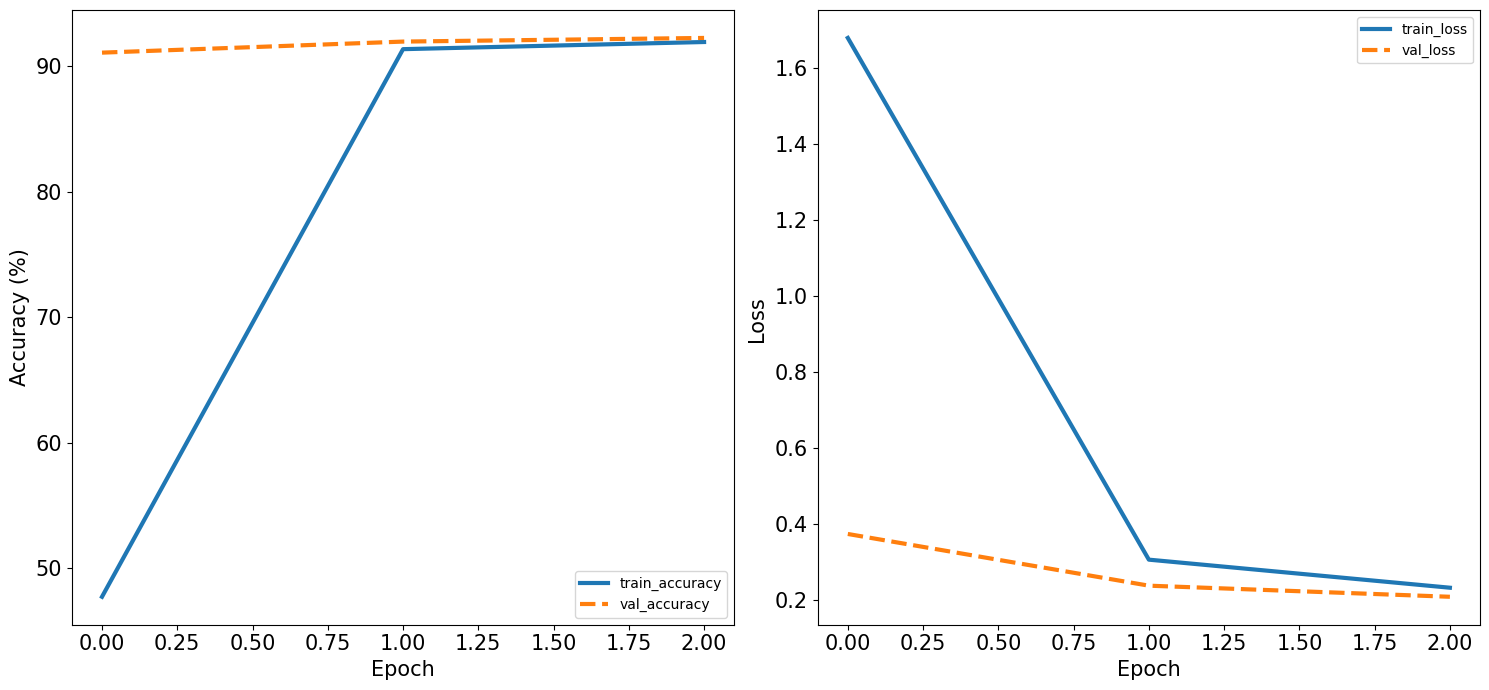

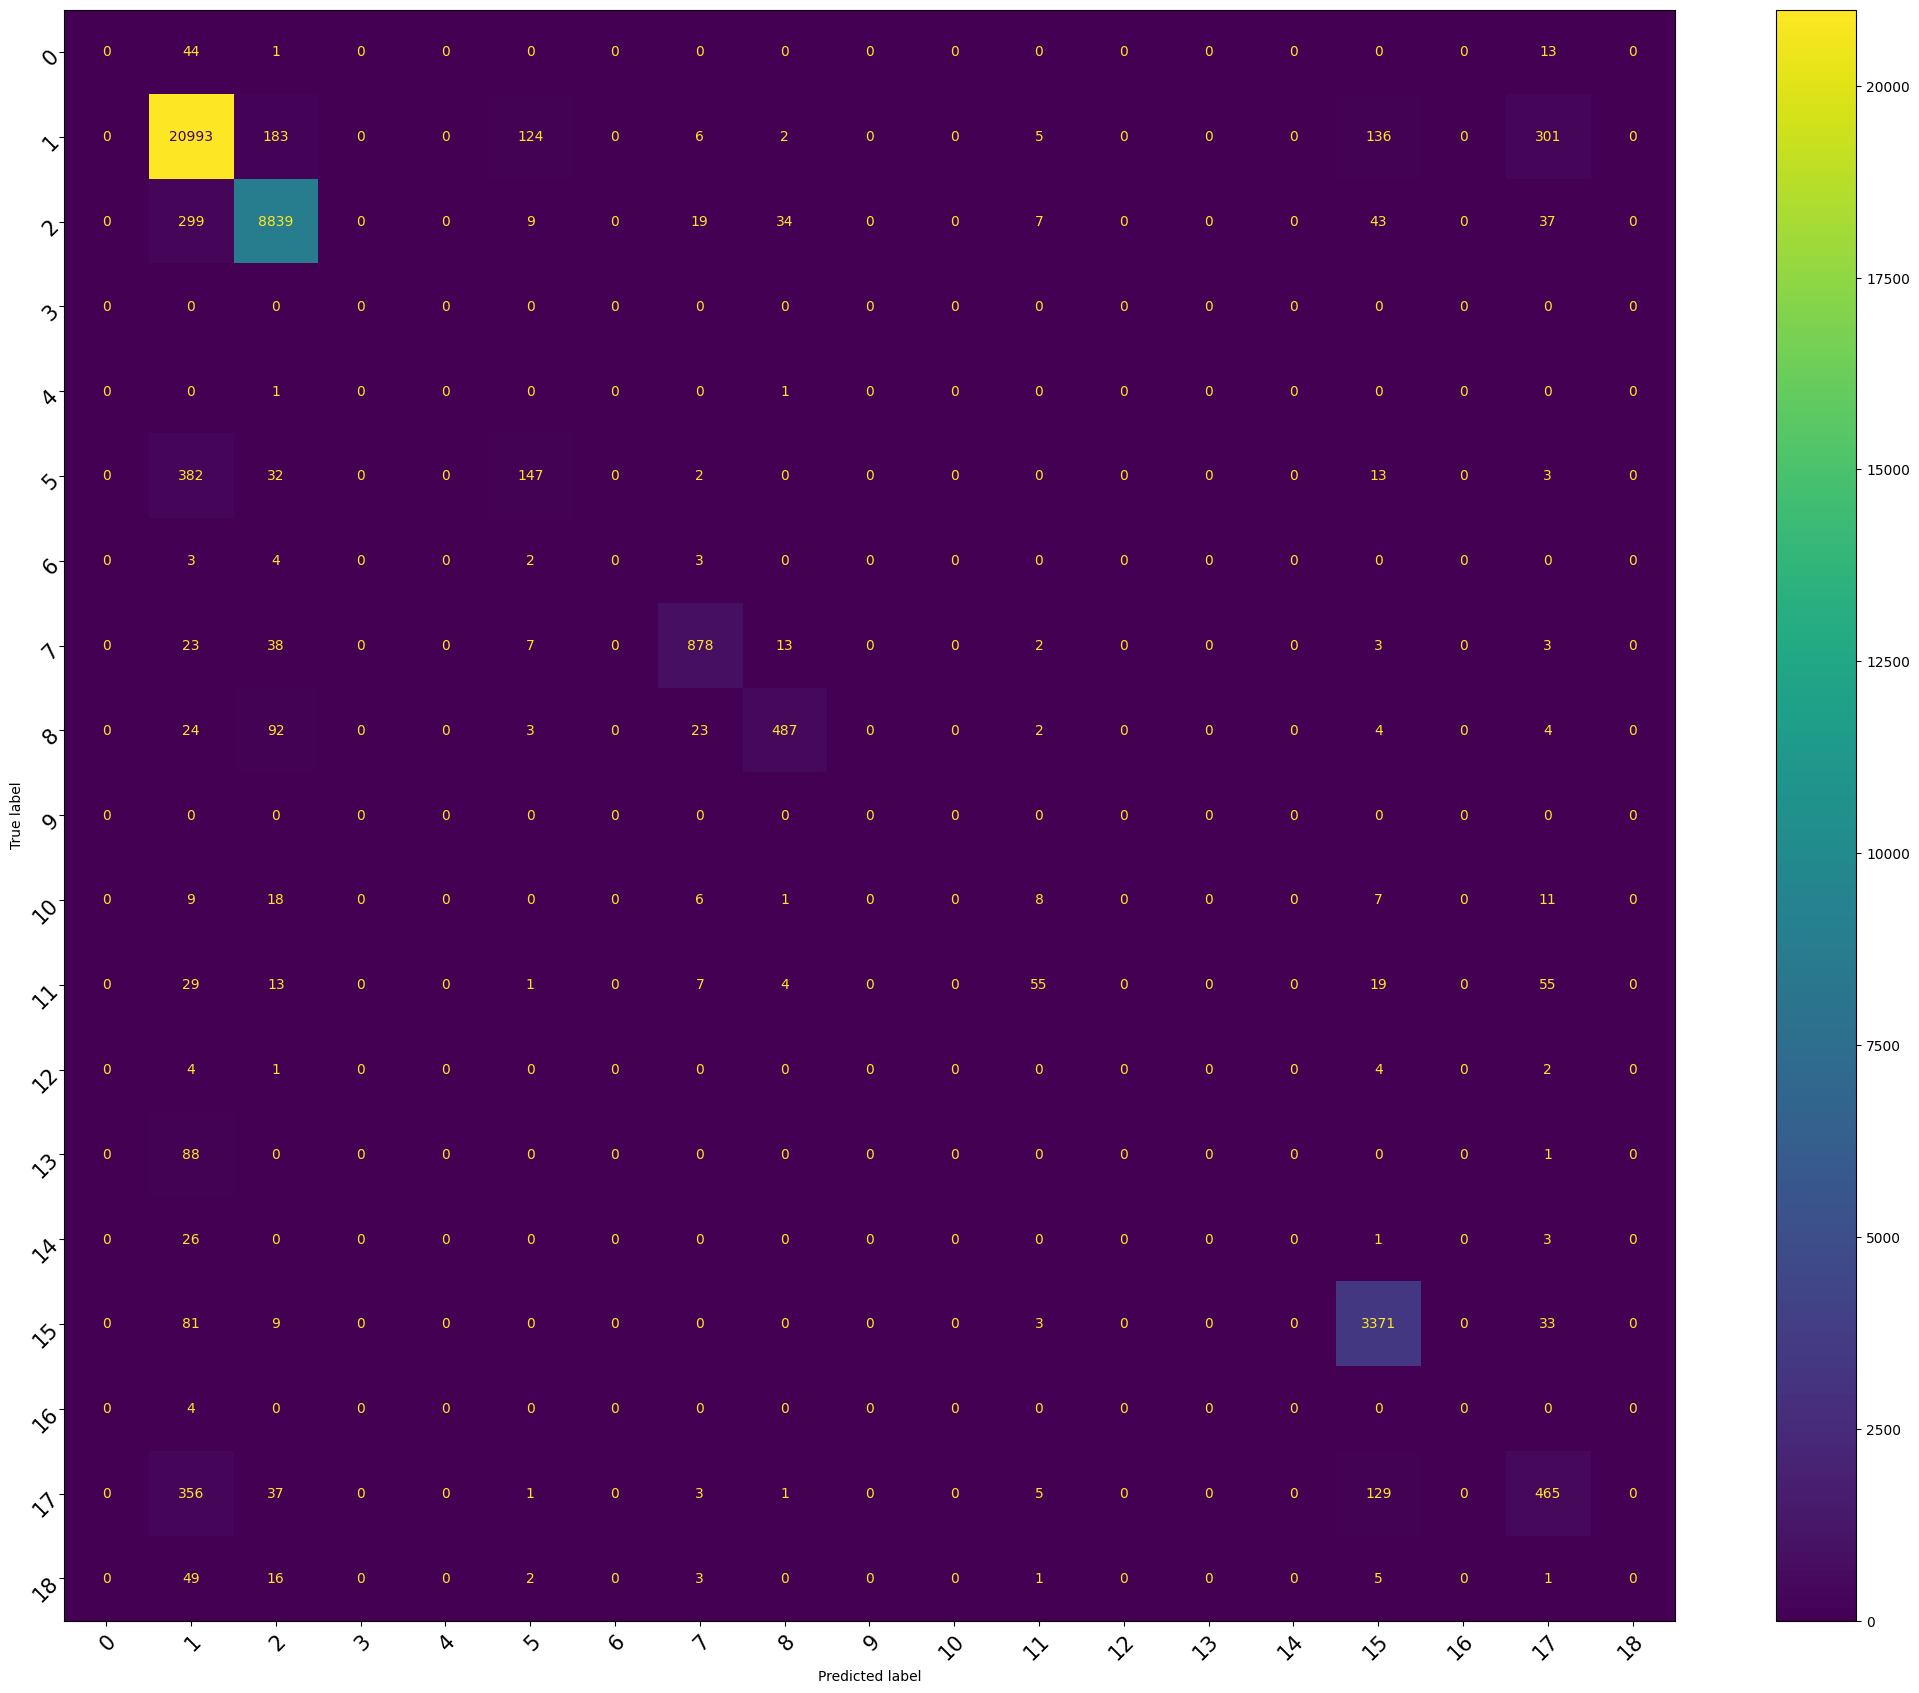

len(dt)0:  191209
len(dt_sepT)0:  98
Starting Fold 5
Train 225, Val 75, Test 75
test_loader:  <torch.utils.data.dataloader.DataLoader object at 0x7f996750edf0>
TOTAL TRAINABLE PARAMETERS : 164083
RATIOS: Spatial  12.1% , Temporal  81.1% , Classifier   6.8%
None
EPOCH 1/3
Step [20/225], Loss: 3.4046, Acc : 1.53
Step [40/225], Loss: 2.9073, Acc : 8.98
Step [60/225], Loss: 2.5595, Acc : 15.83
Step [80/225], Loss: 2.2813, Acc : 22.96
Step [100/225], Loss: 2.0463, Acc : 32.89
Step [120/225], Loss: 1.8503, Acc : 41.61
Step [140/225], Loss: 1.6815, Acc : 48.18
Step [160/225], Loss: 1.5396, Acc : 53.29
Step [180/225], Loss: 1.4233, Acc : 57.34
Step [200/225], Loss: 1.3239, Acc : 60.67
Step [220/225], Loss: 1.2397, Acc : 63.38
Validation . . . 
Loss 0.3323,  Acc 91.11,  IoU 0.2516
EPOCH 2/3
Step [20/225], Loss: 0.3511, Acc : 90.85
Step [40/225], Loss: 0.3358, Acc : 91.07
Step [60/225], Loss: 0.3351, Acc : 91.03
Step [80/225], Loss: 0.3280, Acc : 91.12
Step [100/225], Loss: 0.3220, Acc : 91.19
S

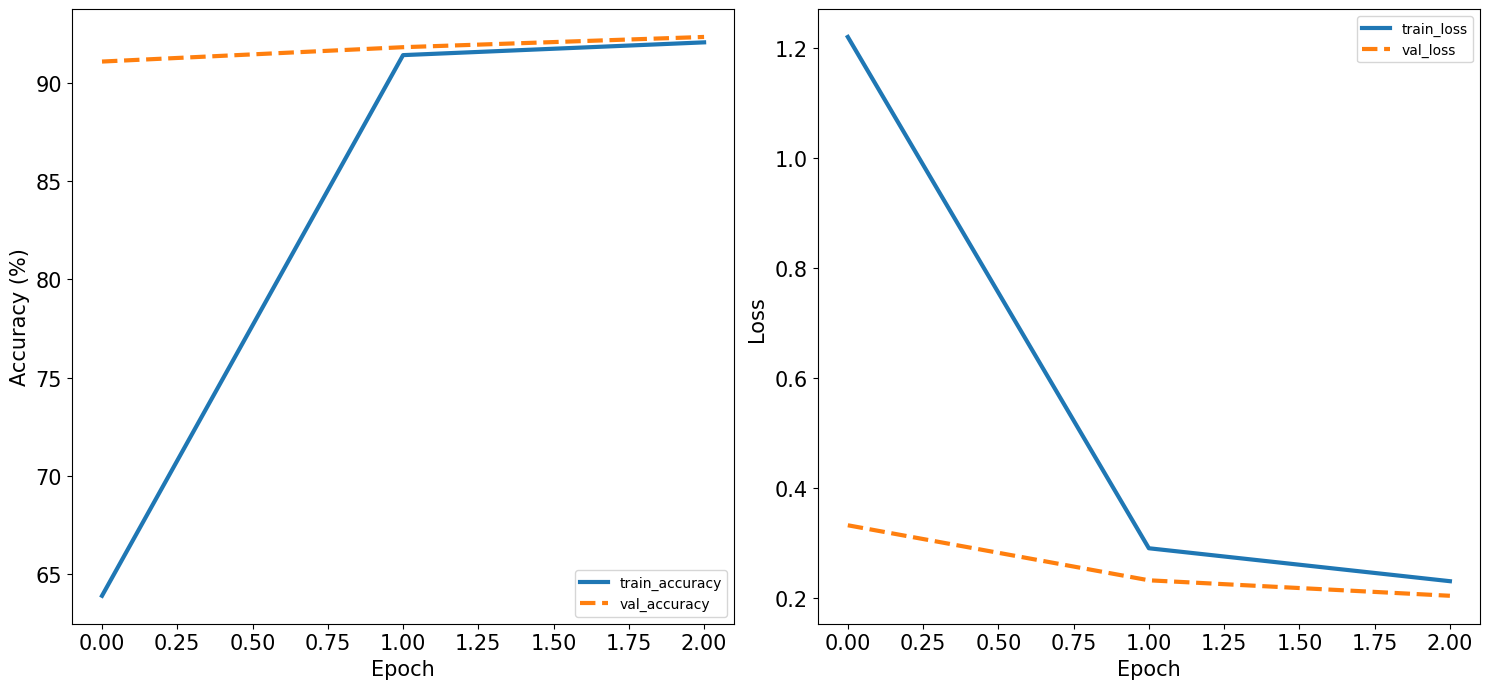

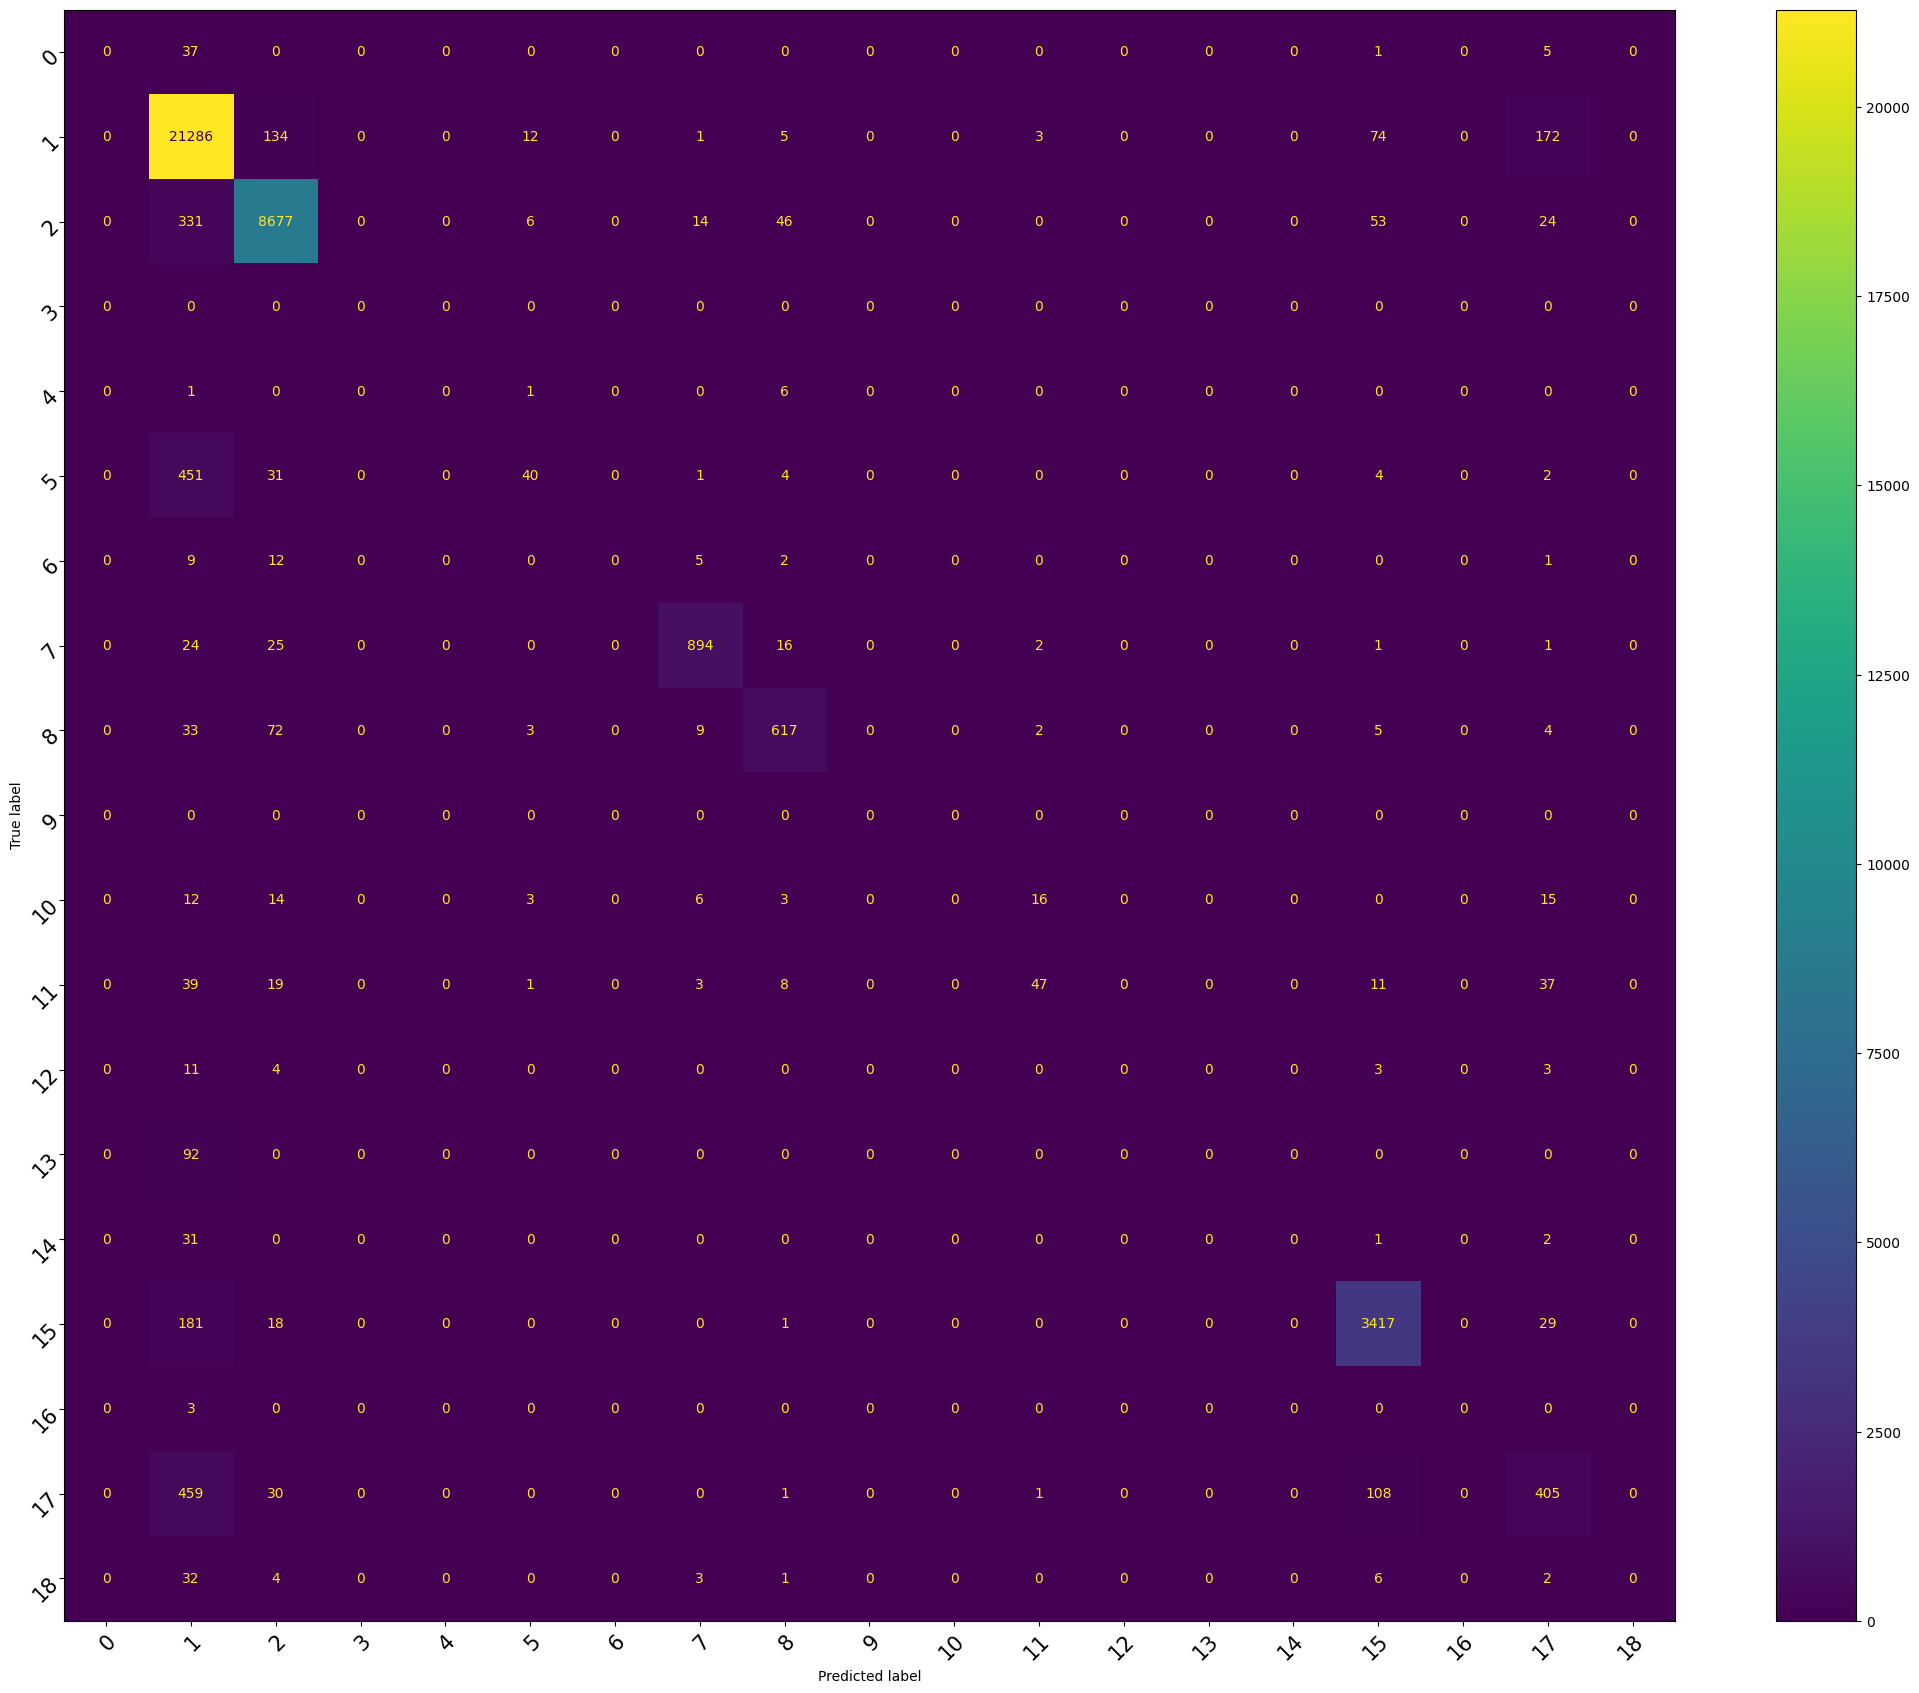

Overall performance:
Acc: 0.9221061770104964,  IoU: 0.2895608727835977


/home/mhbokaei/shakouri/test/Satellite/learning/metrics.py:61: RuntimeWarning: invalid value encountered in double_scalars
  d['Precision'] = tp / (tp + fp)
/home/mhbokaei/shakouri/test/Satellite/learning/metrics.py:60: RuntimeWarning: invalid value encountered in double_scalars
  d['IoU'] = tp / (tp + fp + fn)
/home/mhbokaei/shakouri/test/Satellite/learning/metrics.py:62: RuntimeWarning: invalid value encountered in double_scalars
  d['Recall'] = tp / (tp + fn)
/home/mhbokaei/shakouri/test/Satellite/learning/metrics.py:63: RuntimeWarning: invalid value encountered in double_scalars
  d['F1-score'] = 2 * tp / (2 * tp + fp + fn)


In [6]:
args= parser.parse_args(args=[])
args= vars(args)
for k, v in args.items():
        if 'mlp' in k:
            v = v.replace('[', '')
            v = v.replace(']', '')
            args[k] = list(map(int, v.split(',')))

pprint.pprint(args)
main(args)